No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.
No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 1 MSE: 0.8488


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 2 MSE: 1.3857


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 3 MSE: 0.6830


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 4 MSE: 1.2119


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


Fold 5 MSE: 1.1128

Cross-validation Results:
MSE scores: [0.8488168716430664, 1.3856873512268066, 0.6829690337181091, 1.211946964263916, 1.1128151416778564]
Average MSE: 1.0484 ± 0.2522


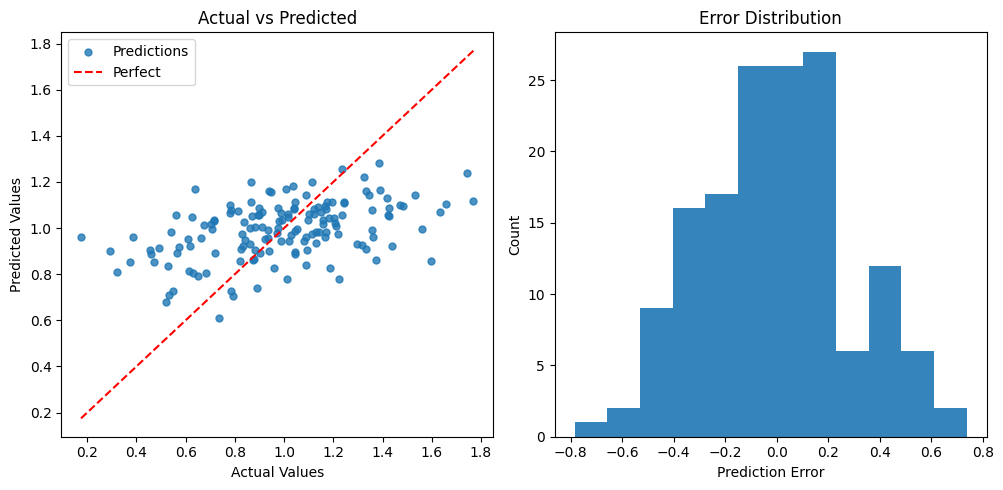

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from qiskit.primitives import StatevectorEstimator

# qiskit + qml
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import StatevectorEstimator as Estimator

from qiskit_machine_learning.algorithms.regressors import VQR
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SPSA, ESCH, ISRES, DIRECT_L_RAND, CRS, ADAM, CG, POWELL
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient

# torch
import torch
import torch.nn as nn
import torch.optim as optim
from qiskit.circuit import QuantumCircuit


# -----------------------------
# Config
# -----------------------------
USE_TORCH = True   # <--- flip to False to use your original VQR path
SEED = 7

# -----------------------------
# Data
# -----------------------------
def generate_data(n_samples=100):
    X = np.random.uniform(0, 1, (n_samples, 4))
    y = 0.5 * X.sum(axis=1) + 0.1 * np.random.randn(n_samples)  # (n,)
    return X, y

# -----------------------------
# Circuits
# -----------------------------
def create_feature_map(n_qubits, num_reps):
    return ZZFeatureMap(feature_dimension=n_qubits, reps=num_reps)

def create_ansatz(n_qubits, num_reps, entanglement='linear'):
    return RealAmplitudes(n_qubits, reps=num_reps, entanglement=entanglement)



# class EstimatorCompat(_StatevectorEstimator):
#     """Adapter so param-shift gradient (old call style) works with V2 Estimator."""
#     def run(self, circuits, observables=None, parameter_values=None, **options):
#         # V2 Estimator prefers circuits positional, others as keywords:
#         return super().run(
#             circuits, 
#             observables=observables, 
#             parameter_values=parameter_values, 
#             **options
#         )


# -----------------------------
# QNN for TorchConnector
# -----------------------------
# def build_estimator_qnn(n_qubits, num_reps):
#     fm = create_feature_map(n_qubits, num_reps)
#     ans = create_ansatz(n_qubits, num_reps, entanglement='linear')

#     # Combine feature map + ansatz into a single circuit
#     # (EstimatorQNN can take a combined circuit with distinct input/weight params)
#     from qiskit.circuit import QuantumCircuit
#     qc = QuantumCircuit(n_qubits)
#     qc.compose(fm, inplace=True)
#     qc.compose(ans, inplace=True)

#     # Observable: Z on all qubits (expectation in [-1, 1])
#     obs = SparsePauliOp("Z" * n_qubits)

#     est = Estimator()
#     # Analytic parameter-shift gradients, compatible with HW and backprop
#     grad = ParamShiftEstimatorGradient(est)

#     qnn = EstimatorQNN(
#         circuit=qc,
#         input_params=fm.parameters,
#         weight_params=ans.parameters,
#         observables=obs,
#         estimator=est,
#         gradient=grad,
#         input_gradients=True,  # needed so TorchConnector can backprop through inputs if required
#     )
#     return qnn


def build_estimator_qnn(n_qubits, num_reps):
    fm = ZZFeatureMap(n_qubits, reps=num_reps)
    ans = RealAmplitudes(n_qubits, reps=num_reps, entanglement='linear')

    qc = QuantumCircuit(n_qubits)
    qc.compose(fm, inplace=True)
    qc.compose(ans, inplace=True)

    obs = SparsePauliOp("Z" * n_qubits)
    est = StatevectorEstimator()  # V2 primitive

    qnn = EstimatorQNN(
        circuit=qc,
        input_params=fm.parameters,
        weight_params=ans.parameters,
        observables=obs,
        estimator=est,
        # Important: don't pass an explicit gradient object here
        # gradient=None (default, V2-compatible internal routine)
        input_gradients=False,   # you don't need d(output)/d(input) for this regression
    )
    return qnn

# Small classical head to scale quantum output ([-1,1]) to real line
class HybridRegressor(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.quantum = TorchConnector(qnn)      # turns QNN into a torch.nn.Module
        self.head = nn.Linear(1, 1)             # learnable scale/shift
    def forward(self, x):
        q = self.quantum(x)                     # (batch, 1)
        return self.head(q)                     # (batch, 1)

# -----------------------------
# VQR path (your original)
# -----------------------------
def setup_quantum_regression_vqr(feature_map, ansatz, which="COBYLA"):
    if which == "SPSA":
        optimizer = SPSA(maxiter=500, learning_rate=0.01, perturbation=0.1)
    elif which == "L_BFGS_B":
        optimizer = L_BFGS_B(maxfun=300)
    elif which == "ESCH":
        optimizer = ESCH()
    elif which == "ISRES":
        optimizer = ISRES()
    elif which == "DIRECT_LRAND":
        optimizer = DIRECT_L_RAND()
    elif which == "CRS":
        optimizer = CRS()
    elif which == "ADAM":
        optimizer = ADAM()
    elif which == "CG":
        optimizer = CG()
    elif which == "POWELL":
        optimizer = POWELL()
    else:  # COBYLA default
        optimizer = COBYLA(maxiter=1000)

    vqr = VQR(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        estimator=Estimator(),  # noiseless statevector
    )
    return vqr

# -----------------------------
# Training / Evaluation
# -----------------------------
def main(opt="COBYLA", num_qubits=4, num_splits=5, num_reps=3, random_state=42, epochs=80, lr=2e-2):
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # data
    X, y = generate_data(n_samples=150)
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()
    Xn = X_scaler.fit_transform(X).astype(np.float32)
    yn = y_scaler.fit_transform(y.reshape(-1, 1)).ravel().astype(np.float32)

    kf = KFold(n_splits=num_splits, shuffle=True, random_state=random_state)
    mses = []

    for fold, (tr, te) in enumerate(kf.split(Xn), 1):
        n_qubits = num_qubits

        if USE_TORCH:
            # ----- TorchConnector path -----
            qnn = build_estimator_qnn(n_qubits, num_reps)
            model = HybridRegressor(qnn)

            X_tr = torch.from_numpy(Xn[tr])
            y_tr = torch.from_numpy(yn[tr]).reshape(-1, 1)
            X_te = torch.from_numpy(Xn[te])
            y_te = torch.from_numpy(yn[te]).reshape(-1, 1)

            opt_t = optim.Adam(model.parameters(), lr=lr)
            loss_fn = nn.MSELoss()

            model.train()
            for _ in range(epochs):
                opt_t.zero_grad()
                pred = model(X_tr)
                loss = loss_fn(pred, y_tr)
                loss.backward()
                opt_t.step()

            model.eval()
            with torch.no_grad():
                yhat = model(X_te).cpu().numpy().ravel()

        else:
            # ----- VQR path (your original) -----
            fm = create_feature_map(n_qubits, num_reps)
            ansatz = create_ansatz(n_qubits, num_reps)
            vqr = setup_quantum_regression_vqr(fm, ansatz, which=opt)
            vqr.fit(Xn[tr], yn[tr])
            yhat = vqr.predict(Xn[te])

        mse = np.mean((yn[te] - yhat) ** 2)
        mses.append(mse)
        print(f"Fold {fold} MSE: {mse:.4f}")

    print("\nCross-validation Results:")
    print("MSE scores:", [float(m) for m in mses])
    print(f"Average MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}")

    # Final in-sample fit (for plotting)
    if USE_TORCH:
        qnn = build_estimator_qnn(num_qubits, num_reps)
        model = HybridRegressor(qnn)
        X_all = torch.from_numpy(Xn)
        y_all = torch.from_numpy(yn).reshape(-1, 1)
        opt_t = optim.Adam(model.parameters(), lr=lr)
        loss_fn = nn.MSELoss()
        model.train()
        for _ in range(epochs):
            opt_t.zero_grad()
            pred = model(X_all)
            loss = loss_fn(pred, y_all)
            loss.backward()
            opt_t.step()
        model.eval()
        with torch.no_grad():
            yhat_n = model(X_all).cpu().numpy().ravel()

    else:
        fm = create_feature_map(num_qubits, num_reps)
        ansatz = create_ansatz(num_qubits, num_reps)
        vqr = setup_quantum_regression_vqr(fm, ansatz, which=opt)
        vqr.fit(Xn, yn)
        yhat_n = vqr.predict(Xn)

    # invert target scaling for the diagnostic plots
    yhat = y_scaler.inverse_transform(yhat_n.reshape(-1, 1)).ravel()

    # -----------------------------
    # Plots
    # -----------------------------
    plt.figure(figsize=(15, 5))

    # 1) actual vs predicted (on full data fit)
    plt.subplot(1, 3, 1)
    plt.scatter(y, yhat, s=25, alpha=0.8, label="Predictions")
    lo, hi = y.min(), y.max()
    plt.plot([lo, hi], [lo, hi], "r--", label="Perfect")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted")
    plt.legend()

    # 2) error hist
    plt.subplot(1, 3, 2)
    plt.hist(y - yhat, bins=12, alpha=0.9)
    plt.xlabel("Prediction Error")
    plt.ylabel("Count")
    plt.title("Error Distribution")

    # 3) (Optional) training trace – if you want, log loss per epoch above and plot here

    plt.tight_layout()
    plt.show()


if __name__ == "__main__":

    """Torchconnector is slower than without torch connector option"""
    # Example: TorchConnector path (hybrid PyTorch)
    USE_TORCH = True
    main(opt="COBYLA", num_qubits=4, num_splits=5, num_reps=3, random_state=42, epochs=80, lr=2e-2)

    # Example: VQR path (Qiskit-only)
    # USE_TORCH = False
    # main(opt="COBYLA", num_qubits=4, num_splits=5, num_reps=3, random_state=42)
